In [2]:
%matplotlib inline




Getting started
===============

This tutorial highlights the basics of the
high-level API for ensemble classes, the model selection suite and
features visualization.

============================  =================================================
                   Tutorials                                            Content
============================  =================================================
`ensemble-guide`         How to build, fit and predict with an ensemble
`model-selection-guide`  How to compare several estimators in one go
`visualization-guide`    Plotting functionality
============================  =================================================

The `advanced high-level API tutorials <ensemble-tutorial>` shows how to
leverage advanced features such as probabilistic layers, feature propagation
etc. For tutorials on low-level mechanics, see
`the mechanics guides <learner_tutorial>`.


Preliminaries
-------------

We use the following setup throughout:



In [3]:
import numpy as np
from pandas import DataFrame
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

seed = 2017
np.random.seed(seed)

data = load_iris()
idx = np.random.permutation(150)
X = data.data[idx]
y = data.target[idx]


Ensemble guide
--------------
Building an ensemble
^^^^^^^^^^^^^^^^^^^^
Instantiating a fully specified ensemble is straightforward and requires
three steps: first create the instance, second add the intermediate layers,
and finally the meta estimator.



In [4]:
from mlens.ensemble import SuperLearner
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# --- Build ---
# Passing a scoring function will create cv scores during fitting
# the scorer should be a simple function accepting to vectors and returning a scalar
ensemble = SuperLearner(scorer=accuracy_score, random_state=seed, verbose=2)

# Build the first layer
ensemble.add([RandomForestClassifier(random_state=seed), SVC()])

# Attach the final meta estimator
ensemble.add_meta(LogisticRegression())

# --- Use ---

# Fit ensemble
ensemble.fit(X[:75], y[:75])

# Predict
preds = ensemble.predict(X[75:])

[MLENS] backend: threading



Fitting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:00

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00


To check the performance of estimator in the layers, call the ``data``
attribute. The attribute can be wrapped in a :class:`pandas.DataFrame`,
but prints in a tabular format as is.



In [5]:
print("Fit data:\n%r" % ensemble.data)

Fit data:
                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  randomforestclassifier       0.89     0.03  0.67  0.03  0.02  0.00
layer-1  svc                          0.83     0.09  0.02  0.01  0.02  0.01



To round off, let's see how the ensemble as a whole fared.



In [6]:
print("Prediction score: %.3f" % accuracy_score(preds, y[75:]))

Prediction score: 0.973


Multi-layer ensembles
^^^^^^^^^^^^^^^^^^^^^

With each call to the ``add`` method, another layer is added to the ensemble.
Note that all ensembles are *sequential* in the order layers are added. For
instance, in the above example, we could add a second layer as follows.



In [7]:
ensemble = SuperLearner(scorer=accuracy_score, random_state=seed)

# Build the first layer
ensemble.add([RandomForestClassifier(random_state=seed), LogisticRegression()])

# Build the second layer
ensemble.add([LogisticRegression(), SVC()])

# Attach the final meta estimator
ensemble.add_meta(SVC())

SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=9787, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...D60E3A8>)],
   n_jobs=-1, name='group-4', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=2017, sample_size=20,
       scorer=<function accuracy_score at 0x0000021DCD60E3A8>,
       shuffle=False, verbose=False)

We now fit this ensemble in the same manner as before:



In [8]:
ensemble.fit(X[:75], y[:75])
preds = ensemble.predict(X[75:])
print("Fit data:\n%r" % ensemble.data)

Fit data:
                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  logisticregression           0.85     0.06  0.15  0.04  0.00  0.00
layer-1  randomforestclassifier       0.89     0.03  0.41  0.08  0.02  0.01
layer-2  logisticregression           0.85     0.06  0.01  0.00  0.00  0.00
layer-2  svc                          0.85     0.06  0.00  0.00  0.00  0.00




.. py:currentmodule:: mlens.model_selection

Model selection guide
---------------------

The work horse class is the :class:`Evaluator`, which allows you to
grid search several models in one go across several preprocessing pipelines.
The evaluator class pre-fits transformers, thus avoiding fitting the same
preprocessing pipelines on the same data repeatedly. Also, by fitting all
models over all parameter draws in one operation, parallelization is
maximized.
The following example evaluates a `Naive Bayes`_ estimator and a
`K-Nearest-Neighbor`_ estimator under three different preprocessing scenarios:
no preprocessing, standard scaling, and subset selection.
In the latter case, preprocessing is constituted by selecting a subset of
features.

The scoring function
^^^^^^^^^^^^^^^^^^^^

.. currentmodule:: mlens.metrics

An important note is that the scoring function must be wrapped by
:func:`make_scorer`, to ensure all scoring functions behave similarly regardless
of whether they measure accuracy or errors. To wrap a function, simple do:



In [9]:
from mlens.metrics import make_scorer
accuracy_scorer = make_scorer(accuracy_score, greater_is_better=True)

.. currentmodule:: mlens.model_selection

The ``make_scorer`` wrapper
is a copy of the Scikit-learn's :func:`sklearn.metrics.make_scorer`, and you
can import the Scikit-learn version as well.
Note however that to pickle the :class:`Evaluator`, you **must** import
``make_scorer`` from ``mlens``.

A simple evaluation
^^^^^^^^^^^^^^^^^^^

Before throwing preprocessing into the mix, let's see how to evaluate a set of
estimator. First, we need a list of estimator and a dictionary of parameter
distributions that maps to each estimator. The estimators should be put in a
list, either as is or as a named tuple (``(name, est)``). If you don't name
the estimator, the :class:`Evaluator` will automatically name the model as the
class name in lower case. This name must be the key in the parameter
dictionary.



In [10]:
from mlens.model_selection import Evaluator
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint

# Here we name the estimators ourselves
ests = [('gnb', GaussianNB()), ('knn', KNeighborsClassifier())]

# Now we map parameters to these
# The gnb doesn't have any parameters so we can skip it
pars = {'n_neighbors': randint(2, 20)}
params = {'knn': pars}

We can now run an evaluation over these estimators and parameter distributions
by calling the ``fit`` method.



In [11]:
evaluator = Evaluator(accuracy_scorer, cv=10, random_state=seed, verbose=1)
evaluator.fit(X, y, ests, params, n_iter=10)

Launching job


C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\mlens\model_selection\model_selection.py:585: UserWarning: No valid parameters found for gnb. Will fit and score once with given parameter settings.
  "settings.".format(key))


Job           done | 00:00:01


The full history of the evaluation can be found in ``cv_results``. To compare
models with their best parameters, we can pass the ``results`` attribute to
a :obj:`pandas.DataFrame` or print it as a table. We use ``m`` to denote
mean values and ``s`` to denote standard deviation across folds for brevity.
Note that the timed prediction is for the training set, for comparability with
training time.



In [12]:
print("Score comparison with best params founds:\n\n%r" % evaluator.results)

Score comparison with best params founds:

       test_score-m  test_score-s  train_score-m  train_score-s  fit_time-m  fit_time-s  pred_time-m  pred_time-s               params
gnb           0.960         0.033          0.957          0.006       0.004       0.002        0.004        0.002                     
knn           0.967         0.033          0.980          0.005       0.003       0.002        0.055        0.010  {'n_neighbors': 15}



Preprocessing
^^^^^^^^^^^^^

Next, suppose we want to compare the models across a set of preprocessing pipelines.
To do this, we first need to specify a dictionary of preprocessing pipelines to
run through. Each entry in the dictionary should be a list of transformers to apply sequentially.



In [13]:
from mlens.preprocessing import Subset
from sklearn.preprocessing import StandardScaler

# Map preprocessing cases through a dictionary
preprocess_cases = {'none': [],
                    'sc': [StandardScaler()],
                    'sub': [Subset([0, 1])]
                    }

The ``fit`` methods determines automatically whether there is any preprocessing
or any estimator jobs to run, so all we need to do is specify the arguments
we want to be processed. If a previous preprocessing job was fitted, those
pipelines are stored and will be used for subsequent estimator fits.

.. currentmodule:: mlens.preprocessing

This can be helpful if the preprocessing is time-consuming, for instance if
the preprocessing pipeline is an ensemble itself. All ensembles implement
a ``transform`` method that, in contrast to the ``predict`` method, regenerates
the predictions made during the ``fit``call. More precisely, the ``transform``
method uses the estimators fitted with cross-validation to construct predictions,
whereas the ``predict`` method uses the final estimators fitted on all data.
This allows us use ensembles as preprocessing steps that mimicks how that ensemble
would produce predictions for a subsequent meta learner or layer. Since fitting
large ensembles is highly time-consuming, fixing the lower layers as preprocessing
input is highly valuable for tuning the higher layers and / or the final meta learner.
See the `model-selection-tutorial` tutorial for
an example. To fit only the preprocessing pipelines, we omit any estimators in the
``fit`` call.



In [14]:
evaluator.fit(X, y, preprocessing=preprocess_cases)

Launching job
Job           done | 00:00:00


Model Selection across preprocessing pipelines
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

To evaluate the same set of estimators across all pipelines with the same
parameter distributions, there is no need to take any heed of the preprocessing
pipeline, just carry on as in the simple case:



In [15]:
evaluator.fit(X, y, ests, params, n_iter=10)
print("\nComparison across preprocessing pipelines:\n\n%r" % evaluator.results)

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\mlens\model_selection\model_selection.py:585: UserWarning: No valid parameters found for none.gnb. Will fit and score once with given parameter settings.
  "settings.".format(key))
C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\mlens\model_selection\model_selection.py:585: UserWarning: No valid parameters found for sc.gnb. Will fit and score once with given parameter settings.
  "settings.".format(key))
C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\mlens\model_selection\model_selection.py:585: UserWarning: No valid parameters found for sub.gnb. Will fit and score once with given parameter settings.
  "settings.".format(key))


Launching job
Job           done | 00:00:04

Comparison across preprocessing pipelines:

             test_score-m  test_score-s  train_score-m  train_score-s  fit_time-m  fit_time-s  pred_time-m  pred_time-s               params
none  gnb           0.960         0.033          0.957          0.006       0.008       0.004        0.004        0.002                     
none  knn           0.967         0.033          0.980          0.005       0.003       0.001        0.057        0.010  {'n_neighbors': 15}
sc    gnb           0.960         0.033          0.957          0.006       0.004       0.002        0.005        0.002                     
sc    knn           0.960         0.044          0.965          0.003       0.004       0.002        0.081        0.035   {'n_neighbors': 8}
sub   gnb           0.780         0.133          0.791          0.020       0.003       0.001        0.003        0.001                     
sub   knn           0.800         0.126          0.837          0

You can also map different estimators to different preprocessing folds, and
map different parameter distribution to each case. We will map two different
parameter distributions



In [16]:
pars_1 = {'n_neighbors': randint(20, 30)}
pars_2 = {'n_neighbors': randint(2, 10)}
params = {'sc.knn': pars_1,
          'none.knn': pars_2,
          'sub.knn': pars_2}

# We can map different estimators to different cases
ests_1 = [('gnb', GaussianNB()), ('knn', KNeighborsClassifier())]
ests_2 = [('knn', KNeighborsClassifier())]
estimators = {'sc': ests_1,
              'none': ests_2,
              'sub': ests_1}

evaluator.fit(X, y, estimators, params, n_iter=10)
print("\nComparison with different parameter dists:\n\n%r" % evaluator.results)

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\mlens\model_selection\model_selection.py:585: UserWarning: No valid parameters found for sc.gnb. Will fit and score once with given parameter settings.
  "settings.".format(key))
C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\mlens\model_selection\model_selection.py:585: UserWarning: No valid parameters found for sub.gnb. Will fit and score once with given parameter settings.
  "settings.".format(key))


Launching job
Job           done | 00:00:04

Comparison with different parameter dists:

             test_score-m  test_score-s  train_score-m  train_score-s  fit_time-m  fit_time-s  pred_time-m  pred_time-s               params
none  knn           0.967         0.045          0.961          0.007       0.003       0.001        0.059        0.008   {'n_neighbors': 3}
sc    gnb           0.960         0.033          0.957          0.006       0.004       0.001        0.006        0.002                     
sc    knn           0.940         0.055          0.959          0.008       0.003       0.001        0.044        0.009  {'n_neighbors': 22}
sub   gnb           0.780         0.133          0.791          0.020       0.004       0.002        0.003        0.001                     
sub   knn           0.800         0.126          0.837          0.015       0.003       0.002        0.054        0.010   {'n_neighbors': 9}




.. py:currentmodule:: mlens.visualization

Visualization guide
-------------------

**Explained variance plot**

The :class:`exp_var_plot` function
plots the explained variance from mapping a matrix ``X`` onto a smaller
dimension using a user-supplied transformer, such as the Scikit-learn
:class:`sklearn.decomposition.PCA` transformer for
Principal Components Analysis.



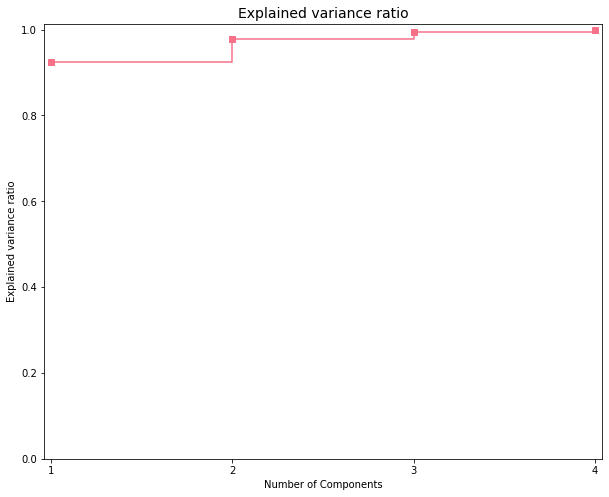

In [17]:
import matplotlib.pyplot as plt
from mlens.visualization import exp_var_plot
from sklearn.decomposition import PCA
exp_var_plot(X, PCA(), marker='s', where='post')

**Principal Components Analysis plot**

The :class:`pca_plot` function
plots a PCA analysis or similar if ``n_components`` is one of ``[1, 2, 3]``.
By passing a class labels, the plot shows how well separated different classes
are.



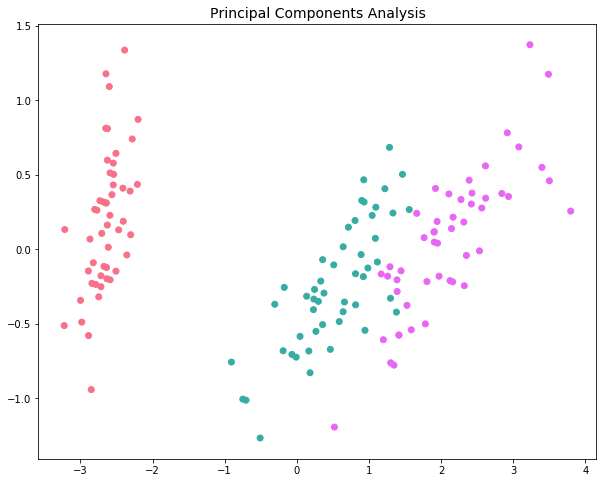

In [18]:
from mlens.visualization import pca_plot
from sklearn.decomposition import PCA
pca_plot(X, PCA(n_components=2), y=y)

**Principal Components Comparison plot**

The :class:`pca_comp_plot` function
plots a matrix of PCA analyses, one for each combination of
``n_components=2, 3`` and ``kernel='linear', 'rbf'``.



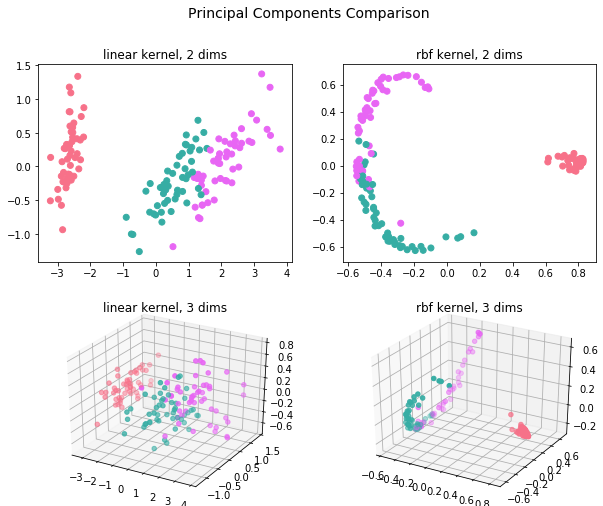

In [19]:
from mlens.visualization import pca_comp_plot
pca_comp_plot(X, y)
plt.show()

**Correlation matrix plot**

The :class:`corrmat` function plots the lower triangle of
a correlation matrix and is adapted the `Seaborn`_ correlation matrix.



C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn

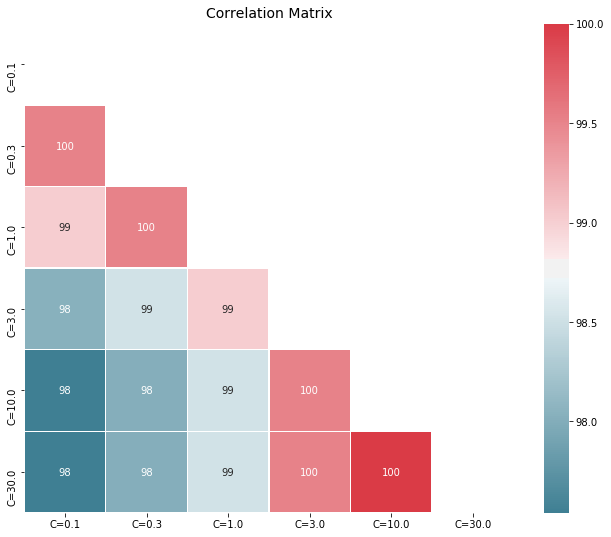

In [20]:
from mlens.visualization import corrmat
# Generate som different predictions to correlate
params = [0.1, 0.3, 1.0, 3.0, 10, 30]
preds = np.zeros((150, 6))
for i, c in enumerate(params):
    preds[:, i] = LogisticRegression(C=c).fit(X, y).predict(X)

corr = DataFrame(preds, columns=['C=%.1f' % i for i in params]).corr()
corrmat(corr)
plt.show()

**Clustered correlation heatmap plot**

The :class:`clustered_corrmap` function is similar to :class:`corrmat`,
but differs in two respects. First, and most importantly, it uses a user
supplied clustering estimator to cluster the correlation matrix on similar
features, which can often help visualize whether there are blocks of highly
correlated features. Secondly, it plots the full matrix (as opposed to the
lower triangle).



In [21]:
from mlens.visualization import clustered_corrmap
from sklearn.cluster import KMeans
Z = DataFrame(X, columns=['f_%i' % i for i in range(1, 5)])

We duplicate all features, note that the heatmap orders features
as duplicate pairs, and thus fully pick up on this duplication.



C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\mlens\visualization\correlations.py:171: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  cls.fit(corr)


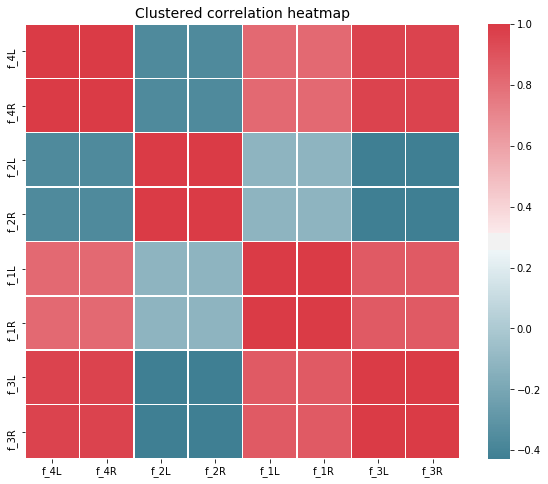

In [22]:
corr = Z.join(Z, lsuffix='L', rsuffix='R').corr()
clustered_corrmap(corr, KMeans())
plt.show()

**Input-Output correlations**

The :class:`corr_X_y` function gives a dashboard of
pairwise correlations between the input data (``X``) and the labels to be
predicted (``y``). If the number of features is large, it is advised to set
the ``no_ticks`` parameter to ``True``, to avoid rendering an illegible
x-axis. Note that ``X`` must be a :class:`pandas.DataFrame`.



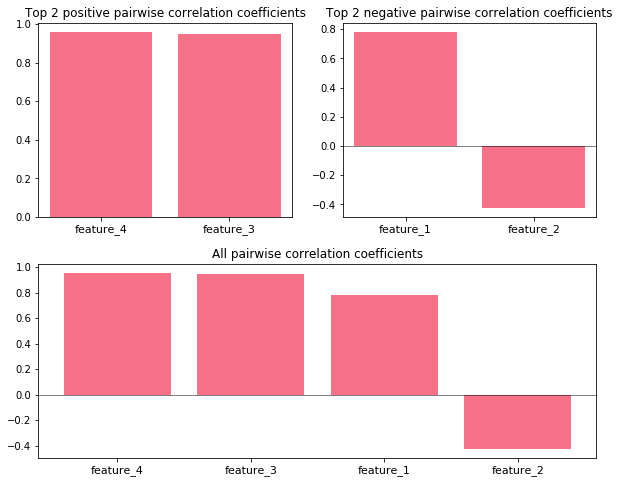

In [23]:
from mlens.visualization import corr_X_y
Z = DataFrame(X, columns=['feature_%i' % i for i in range(1, 5)])
corr_X_y(Z, y, 2, no_ticks=False)
plt.show()